# Camel Crusher analysis

The Camel Crusher has an amazing distortion. Unfortunately, it is not developed for Linux, and the company is not active anymore.

The goal of this analysis is to characterize the distorion and see if it is possible to create a similar sounding cross-platform overdrive.

An amplitude sweep is performed in the following way:

- Fixed frequency sine oscillator source.
- Triangle-wave LFO modulating amplitude slowly (4 second wavelength).
- The input and output of the Camel Crusher is recorded.

In [1]:
import json
import collections
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io.wavfile
import scipy.optimize
import scipy.ndimage.filters

In [2]:
def wav_read_left(filename):
    fs, x = scipy.io.wavfile.read(filename)
    if x.ndim == 2:
        x = np.array(x.T[0])
    
    # Normalize to +/- 1.0
    return x / 2**15

def split_sweep(filename, samples_per_slot):
    x = wav_read_left(filename)
    N = samples_per_slot
    out = []
    for n in range(0, len(x), N):
        out.append(x[n:n+N])
    return out

def env(x, W):
    # Moving maximum
    hW = (W-1)//2 # Half window size
    return scipy.ndimage.filters.maximum_filter1d(x, size=W)[hW:-hW]

def penv(x, W):
    return env(x, W)

def nenv(x, W):
    return -env(-x, W)

def waveshape(x, y, W):
    xenv = np.hstack([nenv(x, W), penv(x, W)])
    yenv = np.hstack([nenv(y, W), penv(y, W)])
    s = np.argsort(xenv)
    xenv = xenv[s]
    yenv = yenv[s]
    
    # Re-sample
    xout = np.linspace(min(xenv), max(xenv), 1000)
    yout = np.interp(xout, xenv, yenv)
    return xout, yout

def decorate_io_plot(ax):
    ax.axis("equal")
    ax.set_xlabel("Input")
    ax.set_ylabel("Output")
    ax.grid(True);
    
def fit_all(f, waveshapes, p0=None):
    # Find parameters to match to f
    fits = collections.OrderedDict()
    fig, ax = plt.subplots(1, 1, figsize=[8, 8])
    for d, (wx, wy) in waveshapes.items():
        popt, pcov = scipy.optimize.curve_fit(f, wx, wy, p0=p0)
        wyfit = f(wx, *popt)

        p = ax.plot(wx, wy, linewidth=5, alpha=0.3, label=d)
        ax.plot(wx, wyfit, color=p[0].get_color(), linestyle="--")

        fits[d] = popt
    decorate_io_plot(ax)
    return fits

def plot_params(fits):
    x = list(fits.keys())

    num_params = len(list(fits.values())[0])
    fig, axs = plt.subplots(num_params, 1, figsize=[12, 5*num_params])

    for n, ax in enumerate(axs):
        y = np.array([params[n] for params in fits.values()])
        
        ax.plot(x, y, ".-")
        ax.set_xlabel("DistTube")
        ax.set_ylabel("Parameter {:d}".format(n))
        ax.grid(True)

def param_table(fits):
    x = list(fits.keys())
    num_params = len(fits[0])
    params = ["P{:d}".format(X) for X in range(num_params)]
    data = dict.fromkeys(params)
    for n, param in enumerate(params):
        y = np.array([params[n] for params in fits.values()])
        data[param] = y
    return pd.DataFrame(data)

## DistTube

### Frequency response

With the gain maxed out (`DistTube = 100`), the waveshaper function is found to be frequency independent. This makes implementation much easier.

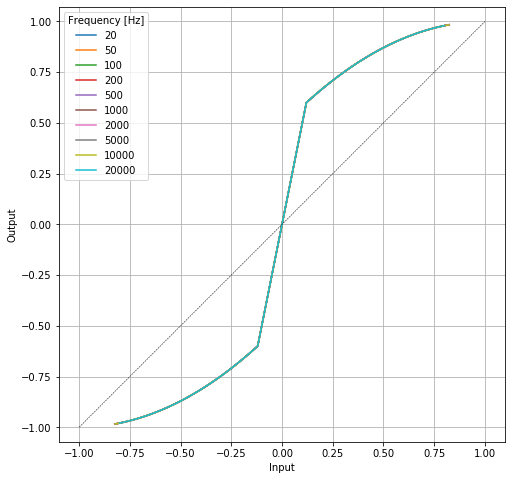

In [3]:
flist = [20,50,100,200,500,1000,2000,5000,10000,20000]
xlist = split_sweep("disttube_freq_sweep/input_mono.wav", 48000*4)
ylist = split_sweep("disttube_freq_sweep/output_mono.wav", 48000*4)
freq_waveshapes = {f: waveshape(xlist[n], ylist[n], 2*48000//f) for n,f in enumerate(flist)}

fig, ax = plt.subplots(1, 1, figsize=[8, 8])

for f, (wx, wy) in freq_waveshapes.items():
    ax.plot(wx, wy, label=f)

linear = [-1, 1]
ax.plot(linear, linear, "k--", linewidth=0.5)

ax.legend(title="Frequency [Hz]")
decorate_io_plot(ax)

### Waveshaper

The function consists of three regions:

- Linear region when the output is between -0.6 and 0.6 roughly.
- Lower saturation region when the output goes below -0.6.
- Upper saturation region when the output goes above 0.6.

So three functions must be fitted.

- The linear region seems to fit perfectly to a straight line.
- The saturated region seems to fit perfectly to a second order polynomial.

The parameters for these two functions vary with the `DistTube` gain parameter so a funciton must be provided for each parameter. A table is generated for each `DistTube` step, as the values are discrete anyway.

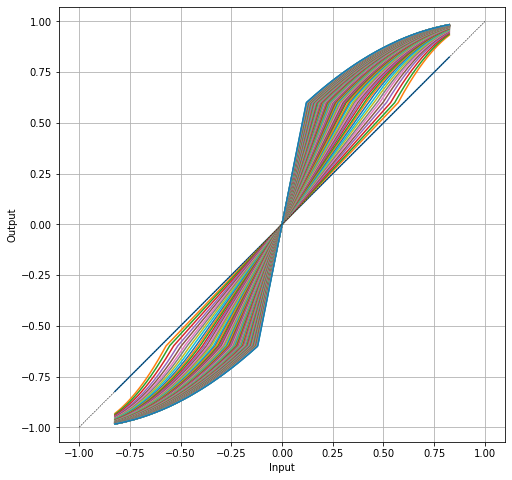

In [4]:
disttubelist = list(range(101))
x = wav_read_left("disttube_sweep/01000Hz_x_mono.wav")
ylist = split_sweep("disttube_sweep/01000Hz_y_mono_sweep.wav", len(x))
disttube_waveshapes = {G: waveshape(x, ylist[G], 2*48000//1000) for G in disttubelist}

fig, ax = plt.subplots(1, 1, figsize=[8, 8])

for d, (wx, wy) in disttube_waveshapes.items():
    ax.plot(wx, wy)

linear = [-1, 1]
ax.plot(linear, linear, "k--", linewidth=0.5)

decorate_io_plot(ax)

### Curve fitting

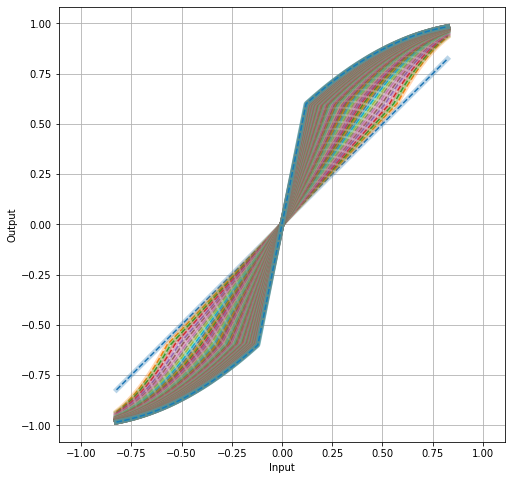

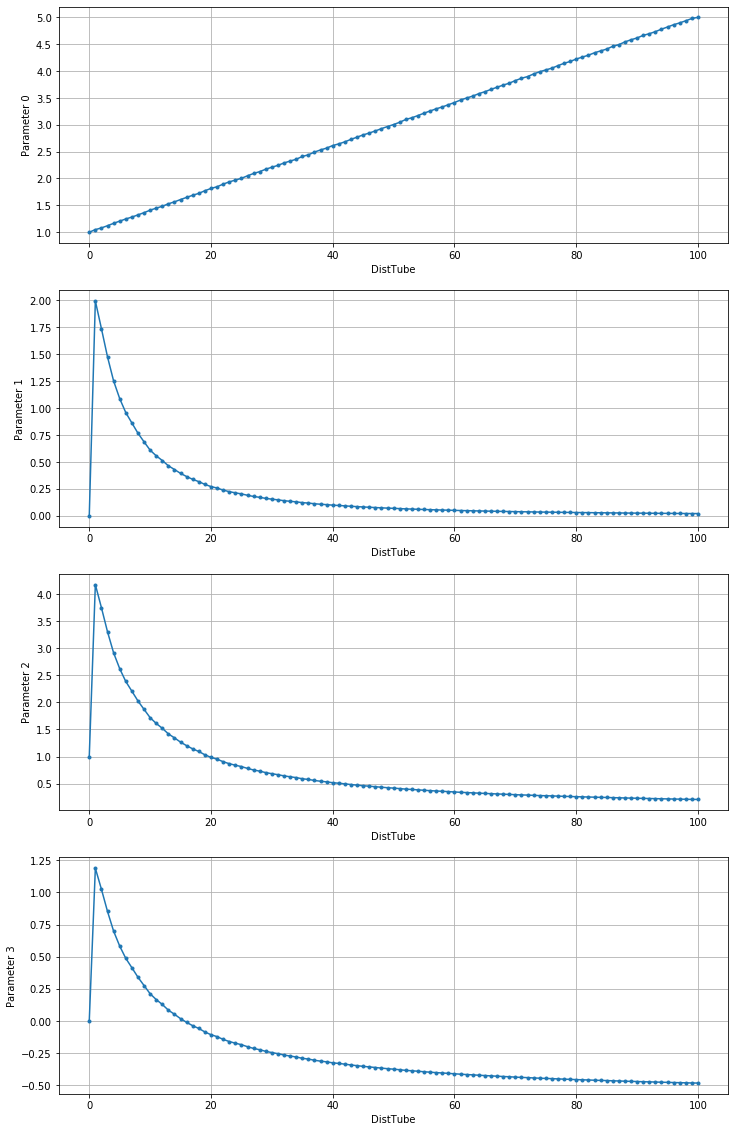

In [5]:
def disttube1(x, p0, p1, p2, p3):
    y = p0*x
    rn = y < -0.6
    rp = y > 0.6
    y[rn] = np.polyval([p1, p2, p3], y[rn])
    y[rp] = np.polyval([-p1, p2, -p3], y[rp])
    return y

fits1 = fit_all(disttube1, disttube_waveshapes, p0=[1, 0, 1, 0])
plot_params(fits1)
df = param_table(fits1)

### Simplified implementation

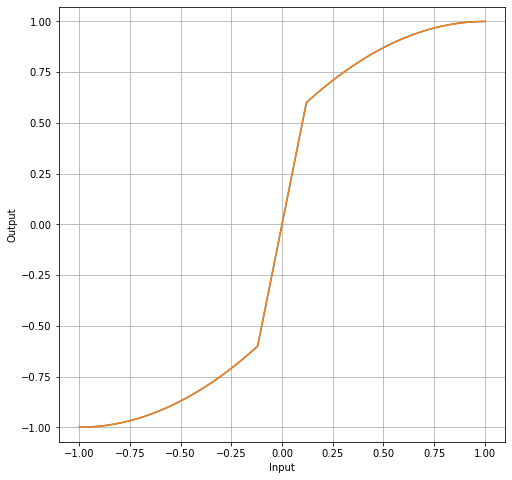

In [6]:
def disttube2(x, p0, p1, p2, p3):
    N = len(x)
    y = np.zeros(N)
    for n in range(N):
        s = p0 * x[n]
        
        if (s < -0.6):
            y[n] = p1*s*s + p2*s + p3
        elif (s > 0.6):
            y[n] = (-p1)*s*s + p2*s + (-p3)
        else:
            y[n] = s

    return y
            
params = fits1[100]
x = np.linspace(-1.0, 1.0, 1000)
y1 = disttube1(x, *params)
y2 = disttube2(x, *params)
fig, ax = plt.subplots(1, 1, figsize=[8, 8])
ax.plot(x, y1)
ax.plot(x, y2)
decorate_io_plot(ax)

### Generate C code

In [7]:
print("#define DISTTUBE_COEFFS_LENGTH {:d}".format(len(df.values)))
print("")
print("const float disttube_coeffs[][4] = {")
print(",\n".join(["    {{ {:g}, {:g}, {:g}, {:g} }}".format(*line) for line in df.values]))
print("};")

#define DISTTUBE_COEFFS_LENGTH 101

const float disttube_coeffs[][4] = {
    { 1, -0.000207935, 0.999713, -9.81884e-05 },
    { 1.048, 1.993, 4.17732, 1.18892 },
    { 1.08, 1.73605, 3.74991, 1.02497 },
    { 1.12095, 1.47375, 3.30412, 0.851922 },
    { 1.16548, 1.25079, 2.91563, 0.699096 },
    { 1.20649, 1.08731, 2.62376, 0.58282 },
    { 1.24634, 0.957433, 2.38663, 0.487302 },
    { 1.28149, 0.861304, 2.20747, 0.414417 },
    { 1.32251, 0.766302, 2.02684, 0.340243 },
    { 1.36353, 0.686164, 1.87118, 0.275696 },
    { 1.4104, 0.60907, 1.71805, 0.211566 },
    { 1.4479, 0.556382, 1.61117, 0.166404 },
    { 1.48306, 0.512929, 1.52144, 0.12821 },
    { 1.52877, 0.463719, 1.41783, 0.0837588 },
    { 1.56509, 0.429445, 1.34426, 0.051955 },
    { 1.60845, 0.39334, 1.26532, 0.017589 },
    { 1.64829, 0.363999, 1.19994, -0.0110755 },
    { 1.68814, 0.337819, 1.14058, -0.0372625 },
    { 1.7233, 0.316995, 1.09257, -0.0585751 },
    { 1.77252, 0.290956, 1.03144, -0.0858797 },
    { 1.8147, 0.

## DistMech

The `DistMech` parameter is much more harsh sounding.

### Frequency response

It seems like this parameter is frequency-independent as well.

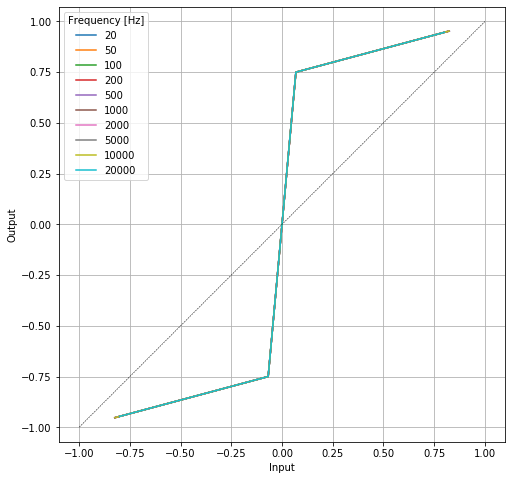

In [8]:
flist = [20,50,100,200,500,1000,2000,5000,10000,20000]
xlist = split_sweep("distmech_freq_sweep/input_mono.wav", 48000*4)
ylist = split_sweep("distmech_freq_sweep/output_mono.wav", 48000*4)
freq_waveshapes = {f: waveshape(xlist[n], ylist[n], 2*48000//f) for n,f in enumerate(flist)}

fig, ax = plt.subplots(1, 1, figsize=[8, 8])

for f, (wx, wy) in freq_waveshapes.items():
    ax.plot(wx, wy, label=f)

linear = [-1, 1]
ax.plot(linear, linear, "k--", linewidth=0.5)

ax.legend(title="Frequency [Hz]")
decorate_io_plot(ax)

### Waveshaper

The function consists of three regions:

- Linear region when the output is between -0.75 and 0.75.
- Lower saturation steep linear region when the output goes below -0.75.
- Upper saturation region when the output goes above 0.75.

So three functions must be fitted.

- The linear region seems to fit perfectly to a straight line.
- The linear region seems to fit perfectly to a steeper straight line.

The parameters for these two functions vary with the `DistMech` gain parameter so a funciton must be provided for each parameter. A table is generated for each `DistMech` step, as the values are discrete anyway.

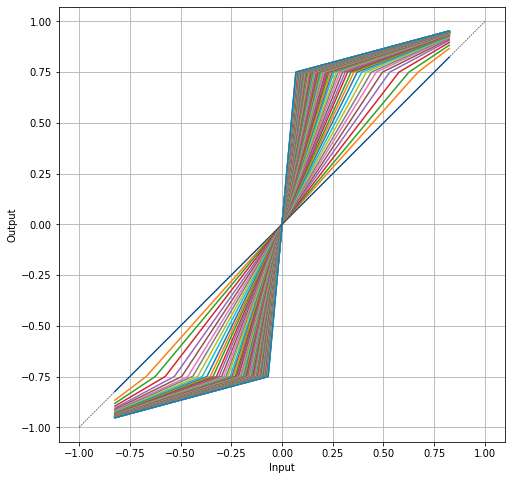

In [9]:
distmechlist = list(range(101))
x = wav_read_left("distmech_sweep/01000Hz_x_mono.wav")
ylist = split_sweep("distmech_sweep/01000Hz_y_mono_sweep.wav", len(x))
distmech_waveshapes = {G: waveshape(x, ylist[G], 2*48000//1000) for G in distmechlist}

fig, ax = plt.subplots(1, 1, figsize=[8, 8])

for d, (wx, wy) in distmech_waveshapes.items():
    ax.plot(wx, wy)

linear = [-1, 1]
ax.plot(linear, linear, "k--", linewidth=0.5)

decorate_io_plot(ax)

### Curve fitting

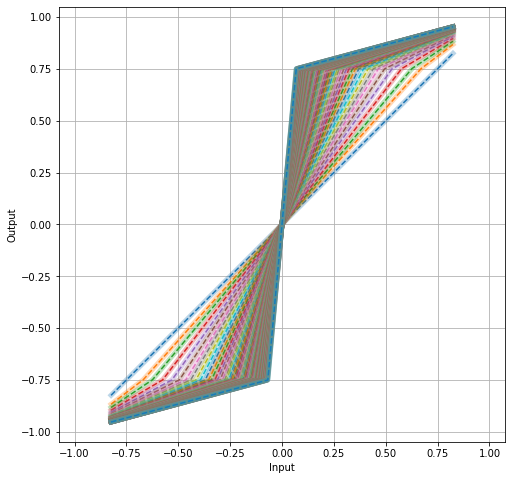

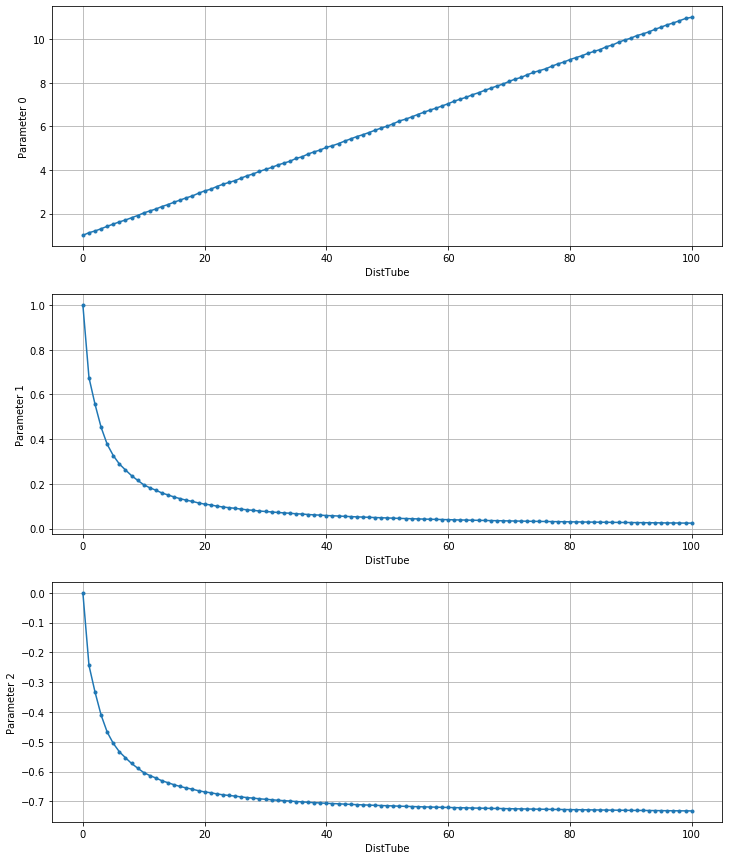

In [10]:
def distmech1(x, p0, p1, p2):
    y = p0*x
    rn = y < -0.75
    rp = y > 0.75
    y[rn] = np.polyval([p1, p2], y[rn])
    y[rp] = np.polyval([p1, -p2], y[rp])
    return y

fits1 = fit_all(distmech1, distmech_waveshapes, p0=[1, 0, 1])
plot_params(fits1)
df = param_table(fits1)

### Simplified implementation

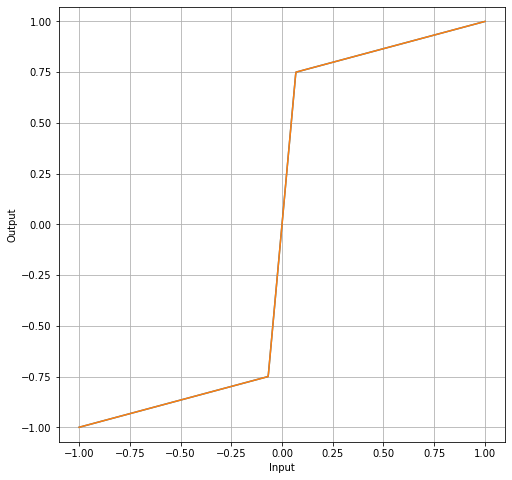

In [11]:
def distmech2(x, p0, p1, p2):
    N = len(x)
    y = np.zeros(N)
    for n in range(N):
        s = p0 * x[n]
        
        if (s < -0.75):
            y[n] = p1*s + p2
        elif (s > 0.75):
            y[n] = p1*s - p2
        else:
            y[n] = s

    return y

params = fits1[100]
x = np.linspace(-1.0, 1.0, 1000)
y1 = distmech1(x, *params)
y2 = distmech2(x, *params)
fig, ax = plt.subplots(1, 1, figsize=[8, 8])
ax.plot(x, y1)
ax.plot(x, y2)
decorate_io_plot(ax)

### Generate C code

In [12]:
print("#define DISTMECH_COEFFS_LENGTH {:d}".format(len(df.values)))
print("")
print("const float distmech_coeffs[][3] = {")
print(",\n".join(["    {{ {:g}, {:g}, {:g} }}".format(*line) for line in df.values]))
print("};")

#define DISTMECH_COEFFS_LENGTH 101

const float distmech_coeffs[][3] = {
    { 1, 1.00007, 5.38307e-05 },
    { 1.12, 0.675717, -0.24321 },
    { 1.2, 0.55556, -0.333334 },
    { 1.30236, 0.452608, -0.410546 },
    { 1.41369, 0.376696, -0.467477 },
    { 1.51623, 0.326275, -0.505295 },
    { 1.61584, 0.28874, -0.533446 },
    { 1.70373, 0.262138, -0.553396 },
    { 1.80626, 0.236686, -0.572485 },
    { 1.9088, 0.215743, -0.588193 },
    { 2.02599, 0.195928, -0.603055 },
    { 2.11975, 0.182516, -0.613115 },
    { 2.20763, 0.171514, -0.621364 },
    { 2.32189, 0.159046, -0.630716 },
    { 2.41269, 0.150358, -0.637232 },
    { 2.5211, 0.141157, -0.644133 },
    { 2.62071, 0.133641, -0.64977 },
    { 2.72032, 0.126885, -0.654837 },
    { 2.80821, 0.121465, -0.658901 },
    { 2.93126, 0.114616, -0.664037 },
    { 3.03673, 0.109328, -0.668004 },
    { 3.11583, 0.105672, -0.670745 },
    { 3.23887, 0.100448, -0.674664 },
    { 3.34141, 0.0964718, -0.677648 },
    { 3.42636, 0.0934101, -0.679